# This notebook is designed to be associated with the paper entitled 

# "The Impact of the COVID-19 Pandemic on Psychiatric Emergency Service Volume and Hospitalization Rates.

## Import necessary libraries and set options

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from collections import namedtuple
from pdq_grid_search import pdq_grid_search

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

sns.set(style='darkgrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [12, 8]})

import warnings
warnings.filterwarnings("ignore")

## Read in and format raw data files

In [2]:
#Denver Health Data
df = pd.read_csv(r'ed_volume_2020.csv', index_col=[0])
df = df[['DateValue','Num_Pes_Designate', 'PesAdmitted']]
df.DateValue = pd.to_datetime(df.DateValue)

In [4]:
#Unity Health Data
unity = pd.read_excel(r'External_Site_Data\unity_covid_data_2020.xlsx', sheet_name=[1])[1]
unity.Date = pd.to_datetime(unity.Date, format='%Y%m%d')
unity = unity[unity.Date > pd.to_datetime('2017-12-31')]

In [5]:
# Merge DH with Unity
df = df.merge(unity, how='inner', left_on='DateValue', right_on='Date').drop('Date', axis=1)

In [6]:
# Columbia Health Data
columbia = pd.read_excel(r'External_Site_Data/Columbia Flow data 2018-2020.xlsx')
columbia = columbia.transpose()
columbia.columns = columbia.iloc[0].values
columbia.drop(['Volumes','Acuity'], axis=1, inplace=True)
columbia.drop(['Unnamed: 0'], inplace=True)
columbia.index = pd.Series(columbia.index)
columbia['DateValue'] = columbia.index

In [7]:
# Merge DH/Unity with Columbia Data
df = df.merge(columbia, how='left', left_on='DateValue',right_on='DateValue')

In [8]:
#Clean column names and clarify site in column titles.
df.rename({'DateValue':'date',
           'Num_Pes_Designate':'D_count',
           'Total psychiatric emergency encounters (n)':'C_count',
           'Volume':'U_count',
           'PesAdmitted':'D_admit',
           'total_admits':'C_admit',
           'Count_Admits':'U_admit',
            'psych_admits':'psych_admits',
            'med_admits':'med_admits',
            'Total psychiatric encounters followed by discharge (n)':'C_disch'}, axis=1, inplace=True)
df.drop(['psych_admits','med_admits'], axis=1, inplace=True)

In [14]:
# Fill NaN values with 0 (Some sites used blank instead of 0 to indicate "no patients")
df = df.fillna(0)

In [15]:
# Create a column to indicate year
df['year'] = df.date.apply(lambda x: x.year)

In [22]:
# Split dataframe into 3 dfs, one for each year. 
# Combine the yearly dataframes for each site to calculate year-over-year differences.
df_2018 = df[df.year==2018].copy().reset_index(drop=True)
df_2019 = df[df.year==2019].copy().reset_index(drop=True)
df_2020 = df[df.year==2020].copy().reset_index(drop=True)

df_dh = pd.DataFrame({'count18':df_2018.D_count,
                     'admit18':df_2018.D_admit,
                     'count19':df_2019.D_count,
                     'admit19':df_2019.D_admit,
                     'count20':df_2020.D_count,
                     'admit20':df_2020.D_admit})

df_columbia = pd.DataFrame({'count18':df_2018.C_count,
                     'admit18':df_2018.C_admit,
                     'count19':df_2019.C_count,
                     'admit19':df_2019.C_admit,
                     'count20':df_2020.C_count,
                     'admit20':df_2020.C_admit})

df_unity = pd.DataFrame({'count18':df_2018.U_count,
                     'admit18':df_2018.U_admit,
                     'count19':df_2019.U_count,
                     'admit19':df_2019.U_admit,
                     'count20':df_2020.U_count,
                     'admit20':df_2020.U_admit})

In [26]:
# Take cumulative sum value for each years column. Used in primary descriptive analyses
df_dh = df_dh.cumsum()
df_unity = df_unity.cumsum()
df_columbia = df_columbia.cumsum()

In [40]:
#Split data into smaller group, looking only to the differences from April 2020 onward.
df_dh_april = df_dh.loc[90:, 'count19':'admit20'].cumsum()
df_unity_april = df_unity.loc[90:, 'count19':'admit20'].cumsum()
df_columbia_april = df_columbia.loc[90:, 'count19':'admit20'].cumsum()

In [34]:
# Create function to expedite percent change (pchange) calculations
def pchange(new, old):
    change = (new-old)/old
    return change

### Descriptive Analysis

In [77]:
print(pchange(4840,5329))
print(pchange(6358,6851))
print(pchange(10354,10832))

-0.09176205667104523
-0.07196029776674938
-0.04412850812407681


In [78]:
print(pchange(1100/4840,1023/5329))
print(pchange(2841/6358,3271/6851))
print(pchange(1926/10354,1894/10832))

0.18390651381853715
-0.06411145097821232
0.06384118366122274


## Time Series Analysis

#### Establish pre/post timeframe around 03/15/2020 with dummy variable (pre_post) with established 

In [51]:
t_zero = pd.to_datetime('03/15/2020', infer_datetime_format=True)
df['pre_post'] = [0 if d < t_zero else 1 for d in pd.to_datetime(df['date'])]
df.index = pd.DatetimeIndex(df['date'], freq='D')
df.drop('date', axis=1, inplace=True)

In [53]:
df_pre = df.loc[df.index < '2020-03-01']
df_post = df.loc[df.index > '2020-03-15']

#### Loop to iterate over count/admit columns for all 3 sites.

                                     SARIMAX Results                                     
Dep. Variable:                           D_count   No. Observations:                 1090
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood                -767.242
Date:                           Tue, 09 Mar 2021   AIC                           1546.484
Time:                                   11:39:31   BIC                           1576.447
Sample:                               01-07-2018   HQIC                          1557.824
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0328      0.038      0.858      0.391      -0.042       0.108
pre_post      -1.8628      0.394     -4.728

                                     SARIMAX Results                                     
Dep. Variable:                           C_count   No. Observations:                 1090
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 7)   Log Likelihood                -958.053
Date:                           Tue, 09 Mar 2021   AIC                           1926.106
Time:                                   11:40:40   BIC                           1951.071
Sample:                               01-07-2018   HQIC                          1935.555
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      2.777      0.005       0.001       0.003
pre_post      -2.7395      0.450     -6.089

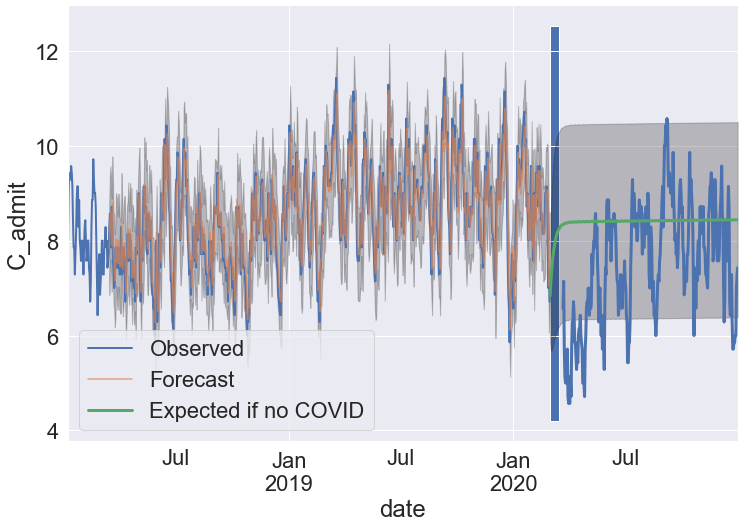

In [59]:
columns_of_interest = ['D_count','D_admit','U_count','U_admit','C_count','C_admit']

for col in columns_of_interest:
    
   # define working data (y) and create rolling average (n=7)
    current_column = col
    y = df[df.index < '2020-03-01'][current_column].rolling(7).mean().dropna()
    y_all = df[[current_column, 'pre_post']].rolling(7).mean().dropna()
    
    # Tune model to best hyperparameters
    param, seasonal_param, aic = pdq_grid_search(y, 2, 2, 2, 7)
    
    # With hyperparameters set, fit model to pre_COVID data
    mod_seasonal = smt.SARIMAX(y, trend='c',
                               order=param, seasonal_order=seasonal_param,
                               simple_differencing=False)
    res_seasonal = mod_seasonal.fit(disp=0)

    mod_seasonal_w_pp = smt.SARIMAX(y_all[current_column], trend='c', exog=y_all['pre_post'],
                               order=param, seasonal_order=seasonal_param,
                               simple_differencing=False)
    res_seasonal_w_pp = mod_seasonal_w_pp.fit(disp=0)
    
    # View summary stats of final model
    print(res_seasonal_w_pp.summary()) 
    
    # obtain values predicted by model, starting on date 'start'
    pred = res_seasonal.get_prediction(start='2018-03-15')

    # obtain values forecasted by model starting with the last value
    pred_uc = res_seasonal.get_forecast(steps=len(df_post)+15)

    # obtain 95% confidence limits for each estimate
    pred_ci = pred.conf_int()
    pred_uc_ci = pred_uc.conf_int()

    # Plot all values above, including rolling average actual data alongside model predictions
    plt.clf()
    plt.close()

#     ax = y.plot(label='Observed', linewidth=2)
#     df_post[current_column].rolling(7).mean().plot(ax=ax, label='_nolegend_', color='b', linewidth=3)
#     pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
#     pred_uc.predicted_mean.plot(ax=ax, label='Expected if no COVID', linewidth=3)
#     ax.fill_between(pred_ci.index,
#                     pred_ci.iloc[:, 0],
#                     pred_ci.iloc[:, 1], color='k', alpha=0.25)
#     ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2020-03-16'), y.index[-1],
#                      alpha=1, zorder=-1)
#     ax.fill_between(pred_uc_ci.index,
#                     pred_uc_ci.iloc[:, 0],
#                     pred_uc_ci.iloc[:, 1], color='k', alpha=0.25)
#     ax.set_ylabel(f'{current_column}')
#     plt.legend(loc='lower left')
#     sns.despine()

    # Save figure
#     plt.savefig(f'Figures\{current_column}.tif', dpi=150)